In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [4]:
df1 = pd.read_csv('Kurla_Station_data_Sheet1 - Kurla_Station_data_Sheet1.csv')
df1.tail()

,From Date,To Date,PM2.5,PM10,NO,NO2,SO2,CO,Ozone,RH,WS,WD,AT
17559,18-03-2023 15:00,18-03-2023 16:00,14.93,217.88,10.18,25.75,25.55,0.33,49.06,62.99,2.59,231.42,32.5
17560,18-03-2023 16:00,18-03-2023 17:00,17.07,250.22,12.9,24.92,25.54,0.26,44.69,66.23,2.86,242.13,31.92
17561,18-03-2023 17:00,18-03-2023 18:00,12.36,236.92,10.55,22.7,25.56,0.23,48.02,70.65,2.54,243.53,31.17
17562,18-03-2023 18:00,18-03-2023 19:00,13.25,189.68,10.98,24.55,25.55,0.25,43.67,77.6,2.05,244.63,30.36
17563,18-03-2023 19:00,18-03-2023 19:08,NaN,None,None,None,None,None,None,None,None,None,None


In [ ]:
# Load the dataset
df = pd.read_csv('kurla_cleaned.csv')
df=df.drop(df[['date']],axis=1)
# Select the feature to be predicted
target_col = 'PM2.5'

In [ ]:
# Normalize the dataset
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[target_col].values.reshape(-1, 1))

In [ ]:
# Split the dataset into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

In [ ]:
# Create the input and output sequences for the LSTM model
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data)-lookback-1):
        X.append(data[i:(i+lookback), 0])
        y.append(data[(i+lookback), 0])
    return np.array(X), np.array(y)

In [ ]:
lookback = 24 # number of hours to look back
X_train, y_train = create_dataset(train_data, lookback)
X_test, y_test = create_dataset(test_data, lookback)

In [ ]:
# Reshape the input sequences for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64)

# Predict the PM2.5 levels for the test set
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

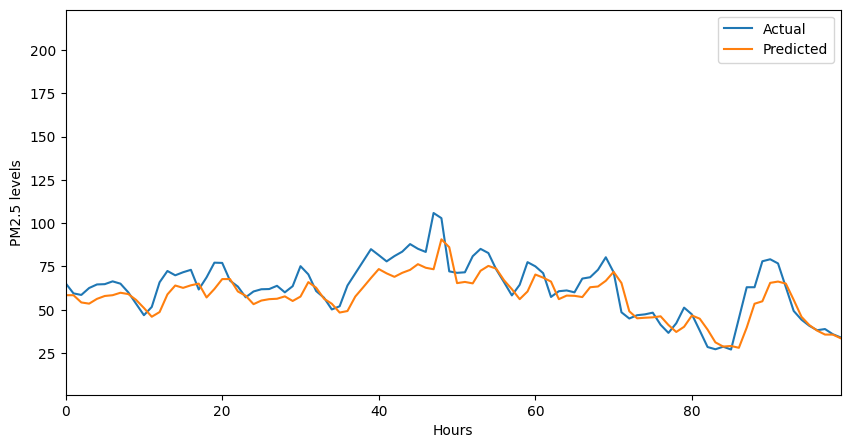

In [3]:
# Plot the predicted vs actual PM2.5 levels
import matplotlib.pyplot as plt

# plt.plot(y_test, label='Actual')
# plt.plot(y_pred, label='Predicted')
# plt.legend()
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(y_test[1000:1300], label='Actual')
ax.plot(y_pred[1000:1300], label='Predicted')
ax.set_xlim(0, 99)  # set x-axis limit to show only the first 100 data points
ax.set_xlabel('Hours')
ax.set_ylabel('PM2.5 levels')
ax.legend()
plt.show()